In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torchvision import transforms
import torchvision.models as models
from skimage import io, transform
from PIL import Image
import os
import matplotlib.pyplot as plt
from torch.autograd import Variable
import matplotlib as mpl
import numpy as np

import cv2
%matplotlib inline

mpl.rcParams['figure.dpi']= 300

In [2]:
def BoundingBoxes(im1, area_thresh = 20):
    boxes = []
    im = cv2.GaussianBlur(im1,(5,5),0)
    imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(imgray,127,255,0)
    thresh = cv2.bitwise_not(thresh)
    im2, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    #cv2.drawContours(im, contours, -1, (0,255,0), 1)
    for c in contours:
        # get the bounding rect
        x, y, w, h = cv2.boundingRect(c)
        area = w*h
        if area < area_thresh:
            continue
        boxes.append((x,y,w,h))
        # draw a green rectangle to visualize the bounding rect
        cv2.rectangle(im1, (x, y), (x+w, y+h), (0, 255, 0), 1)
    return im1, boxes

In [3]:
class Dataset(data.Dataset):
    def __init__(self,data_filename, formula_filename, transform =None):
        self.data_filename = data_filename
        self.formula_filename = formula_filename
        self.files = open(self.data_filename,'r').readlines()
        self.formulas = open(self.formula_filename,'r').readlines()
        self.transform = transform
    def __len__(self):
        return len(self.files)
    def __getitem__(self, index):
        line_num, img_file = self.files[index].strip().split()[0:2]
        img_file += ".png"
        img_path = os.path.join('formula_images/', img_file)
        #image = io.imread(img_path)
        #image = Image.open(img_path).convert('RGB')
        #image = Image.Image.crop(image,box=[200,100,1500,800])
        image = cv2.imread(img_path)
        image = image[300:600,200:1500]
        formula = self.formulas[int(line_num)]
        if self.transform:
            image = self.transform(image)
        return image, formula

In [4]:
dataset_train = Dataset('im2latex_train.lst','im2latex_formulas.lst')

\left\{\begin{array}{lcll}\phi ~ (\infty) &=& 0 & ,  \vspace{3mm}\\ \phi ~ (0) &=&1 & .\end{array} \right.\label{214}



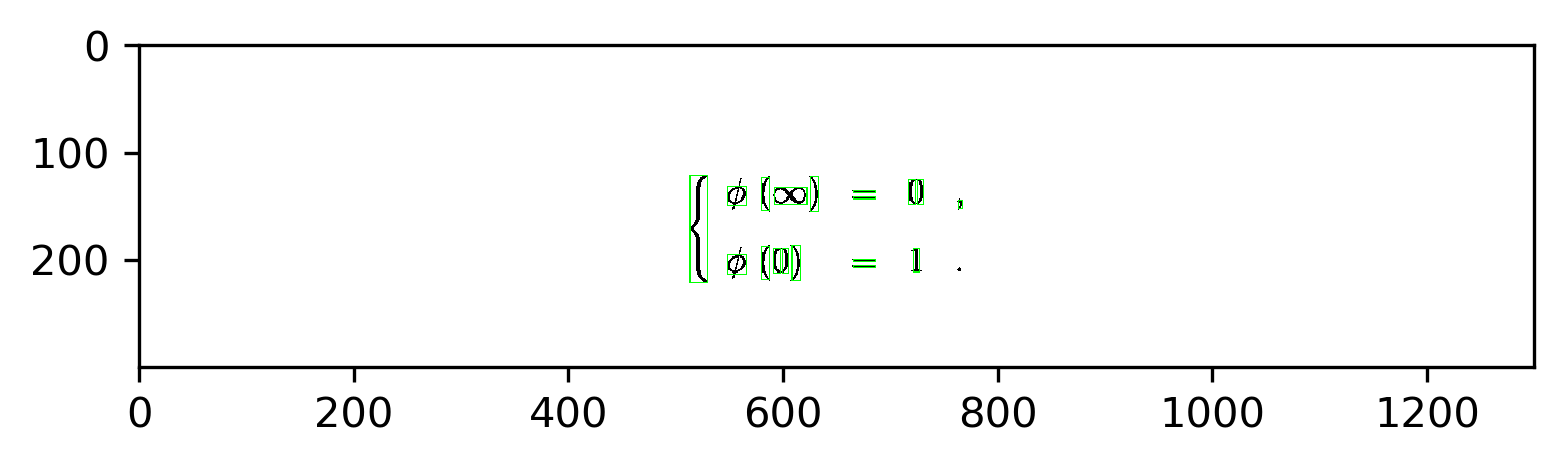

In [8]:
img , label = dataset_train[40]
print label
img, boxes = BoundingBoxes(img,area_thresh=10)
plt.imshow(img)
plt.show()

# Convnet for feature extraction  
Append co-ordinates of feature to feature vector

In [6]:
encoder = models.vgg16(pretrained=True)

In [15]:
#ROI each bounding box and pass through Convnet
def encode(image, boxes, encoder):
    encoded = []
    for box in boxes:
        x,y,w,h = box
        roi = image[x:x+w,y:y+h]
        en = encoder(roi)
        #generate mean pooled feature vextor
        en.extend([box[0],box[1]])
        encoded.append(en)
    return encoded

# Latex language model

![Image Top Down Attention](td1.png)

![td2](td2.png)

![td3](td3.png)

In [ ]:
class Attend(nn.Module):
    def __init__(self, feature_length, tdlstm_hidden_length, hidden):
        super(Attend, self).__init__()
        self.feature_length = feature_length
        self.tdlstm_hidden_length = tdlstm_hidden_length
        self.hidden = hidden
        
        self.lin1 = nn.Linear(feature_length + tdlstm_hidden_length , hidden,bias=False)
        self.lin2 = nn.Linear(hidden, 1, bias=False)
    
    def forward(self, encoder_features, llstm_hidden):
        """
        encoder_features - list of encoded feature vectors for each bounding box
        llstm_hidden - language lstm hidden state
        """
        K = len(encoder_features)
        alphas = []
        for feature in encoder_features:
            v_h = torch.cat((feature,llstm_hidden),dim=0) #unit check dimension
            a_i = self.lin2(F.tanh(self.lin1(v_h)))
            alphas.append(a_i)
        alphas = F.softmax(torch.Tensor(alphas))
        v_t = (alphas * encoder_features).sum(1) # unit test check sum dimension
        
        return v_t
            
        
        

In [12]:
class TDAttnLSTM(nn.Module):
    def __init__(self, hidden, h2_length, latex_vocab, embed_length, encoded_length):
        super(DecoderAttn, self).__init__()
        self.hidden = hidden

        self.embedding = nn.Embedding(latex_vocab, embed_length)
        self.lstm = nn.LSTM(embed_length + encoded_length + h2_length, hidden)
        
        
    def forward(h1_prev, h2, v, prev_embedding):
        '''
        v - mean pooled feature vector
        '''
        lstm_in = torch.cat((h2, v, prev_embedding), dim = 1) #check dimension
        h1_next = self.lstm(lstm_in)
        return h1_next

In [13]:
class LangLSTM(nn.Module):
    def __init__(self, hidden, h1_length, encoded_length):
        super(LangLSTM, self).__init__()
        self.hidden = hidden
        self.lstm = nn.LSTM(h1_length + encoded_length, hidden)
        
    def forward(self, h1_prev, v):
        '''
        v - attention applied feature vector
        '''
        lstm_in = torch.cat((h1_prev, v), dim = 1)
        h2_next = self.lstm(lstm_in)
        token_next = F.softmax(h2_next)
        return h2_next, token_next